In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### This is a data set of movies from TMDB, containing information on budget, genres, production, release information, revenue, user rating, and more. I will do some analysis to determine how these quantities relate to each other.

Import the movies data

In [13]:
movies_df = pd.read_csv('/home/michael/Documents/MachineLearning/kaggle/movies/tmdb_5000_movies.csv')

In [3]:
np.shape(movies_df)

(4803, 20)

4803 movies, each with 20 features.
Let's have a look at an example:

In [4]:
movies_df.ix[0]

budget                                                          237000000
genres                  [{"id": 28, "name": "Action"}, {"id": 12, "nam...
homepage                                      http://www.avatarmovie.com/
id                                                                  19995
keywords                [{"id": 1463, "name": "culture clash"}, {"id":...
original_language                                                      en
original_title                                                     Avatar
overview                In the 22nd century, a paraplegic Marine is di...
popularity                                                        150.438
production_companies    [{"name": "Ingenious Film Partners", "id": 289...
production_countries    [{"iso_3166_1": "US", "name": "United States o...
release_date                                                   2009-12-10
revenue                                                        2787965087
runtime                               

#### Investigate relationship between budget and average vote.
Define budget_vote to be the matrix of just budget and average vote for each movie

In [5]:
budget_vote = movies_df.values[:,[0,18]]
budget_vote = budget_vote.astype(float)

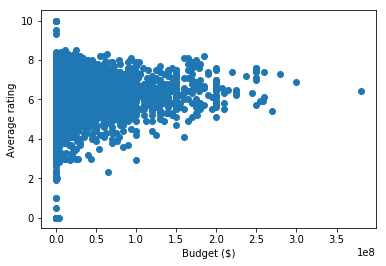

In [6]:
plt.scatter(budget_vote[:,0],budget_vote[:,1])
plt.xlabel('Budget ($)')
plt.ylabel('Average rating')
plt.show()

Looks a bit messy, but with a slight increase in rating as more money is spent. We can use linear regression to find the overall trend:

In [7]:
import linear_regression
import PCA
budget_vote, means, stds = PCA.data_normalisation(budget_vote, invertible=True)
lin = linear_regression.linear_regressor(budget_vote[:,0],budget_vote[:,1],0.0001,100000)

Note that the values of both features have been normalised for the gradient descent process; the values of the means/standard deviation have been stored.

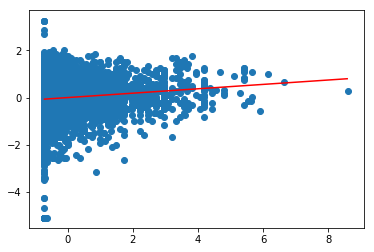

In [8]:
theta = lin.gradient_descent(np.array([0.,0.]),plot='on')

In [9]:
theta

array([ -4.32454073e-16,   9.31457453e-02])

We must now un-normalise to find the true parameters.

In [10]:
true_theta = np.array([means[1] + stds[1]*theta[0] - means[0]*stds[1]*theta[1]/stds[0],theta[1]*stds[1]/stds[0]])
true_theta

array([  6.01280663e+00,   2.73247805e-09])

So average_vote estimate = 6 + (2.7 * 10^-9) * budget. In other words, a movie with zero budget is expected to get 6/10, and an increase in the budget of 100,000,000 dollars is expected to give a rating boost of 0.27. So spending more money isn't a sure way to increase the rating.

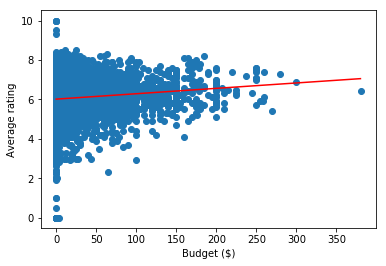

In [12]:
mini = np.amin(budget_vote[:,0])
maxi = np.amax(budget_vote[:,0])
plt.scatter(budget_vote[:,0],budget_vote[:,1])
plt.xlabel('Budget ($)')
plt.ylabel('Average rating')
plt.plot(np.arange(mini, maxi, 0.1), (true_theta[0] + 1000000*true_theta[1]*np.arange(mini, maxi, 0.1)),color='r')
plt.show()

In [23]:
np.amax(budget_vote[:,0])

380000000.0

To add here: Maybe splitting the films into genres may show differences? For example, sci-fi movies may improve as more money can be spent on effects, but others genres mat depend less on this

Another feature in the data set is 'popularity'; TMDB loosely defines this, saying it depends on user rating, page views, favourites and list additions. It also more heavily favours recent films. Let's have a look at the effect of a film's budget on popularity.

In [55]:
movies_df = movies_df.dropna(subset=['release_date','revenue','runtime','vote_count'])
vote_pop = movies_df.values[:,[11,8]]

In [56]:
import time
import datetime
for i in np.arange(np.size(vote_pop, axis=0)):
    vote_pop[i,0] = time.mktime(datetime.datetime.strptime(vote_pop[i,0], "%Y-%m-%d").timetuple())

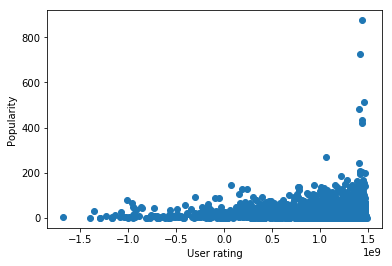

In [77]:
plt.scatter(vote_pop[:,0],vote_pop[:,1])
plt.xlabel('User rating')
plt.ylabel('Popularity')
plt.show()

In [73]:
np.log(vote_pop[:,1].astype(float))

array([ 5.01354823,  4.93506811,  4.67634403, ...,  0.36774663,
       -0.15430803,  0.65745938])

In [19]:
budget_pop = movies_df.values[:,[0,8]].astype(float)
budget_pop = PCA.data_normalisation(budget_pop)

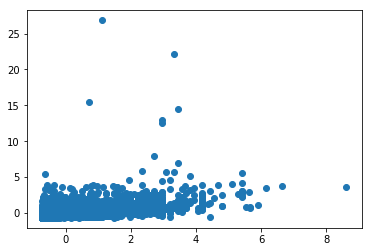

In [20]:
plt.scatter(budget_pop[:,0],budget_pop[:,1])
plt.show()

In [21]:
linpop = linear_regression.linear_regressor(budget_pop[:,0],budget_pop[:,1],0.0001,100000)

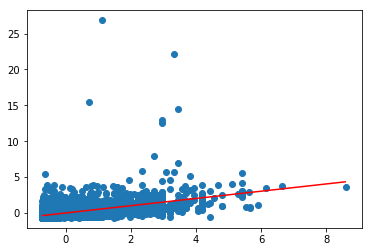

In [22]:
thetapop = linpop.gradient_descent(np.array([0.,0.]),plot='on')

In [15]:
thetapop

array([  2.90434343e-17,   5.05413999e-01])

#### Popularity also increases with budget.

#### Let's isolate some figures which may be predictive of rating/popularity.

In [16]:
movies_df.ix[0]

budget                                                          237000000
genres                  [{"id": 28, "name": "Action"}, {"id": 12, "nam...
homepage                                      http://www.avatarmovie.com/
id                                                                  19995
keywords                [{"id": 1463, "name": "culture clash"}, {"id":...
original_language                                                      en
original_title                                                     Avatar
overview                In the 22nd century, a paraplegic Marine is di...
popularity                                                        150.438
production_companies    [{"name": "Ingenious Film Partners", "id": 289...
production_countries    [{"iso_3166_1": "US", "name": "United States o...
release_date                                                   2009-12-10
revenue                                                        2787965087
runtime                               

In [31]:
movies_df = movies_df.dropna(subset=['release_date','revenue','runtime','vote_count'])

In [192]:
film_figures_rating = movies_df.values[:,[0,11,12,13,19,18]]
np.random.shuffle(film_figures_rating)
film_figures = film_figures_rating[:,:-1]
rating = film_figures_rating[:,-1]

In [193]:
import time
import datetime
for i in np.arange(np.size(film_figures, axis=0)):
    film_figures[i,1] = time.mktime(datetime.datetime.strptime(film_figures[i,1], "%Y-%m-%d").timetuple())

In [194]:
film_figures = film_figures.astype(float)

In [196]:
rating = rating.astype(float)

In [197]:
film_figures = PCA.data_normalisation(film_figures)

In [198]:
ratio = 0.7
film_figures_train = film_figures[:int(ratio*len(film_figures)),:]
film_figures_test = film_figures[int(ratio*len(film_figures)):,:]
rating_train = rating[:int(ratio*len(film_figures))]
rating_test = rating[int(ratio*len(film_figures)):]

In [253]:
rating_model = linear_regression.linear_regressor(film_figures_train, rating_train, 0.0001, 500)

In [254]:
theta = rating_model.gradient_descent(np.array([0.,0.,0.,0.,0.,0.]))
rating_model.cost_function(theta)

1.0794579155793995

In [201]:
rating_predict = linear_regression.linear_regressor(film_figures_test, rating_test, 0.0001, 10000)

In [202]:
error = np.sqrt(rating_predict.cost_function(theta))

In [203]:
error

1.0676885401152216

#### Average error in rating prediction is 1.07

In [272]:
film_figures_rating = movies_df.values[:,[0,11,12,13,19,18]]
import time
import datetime
for i in np.arange(np.size(film_figures, axis=0)):
    film_figures_rating[i,1] = time.mktime(datetime.datetime.strptime(film_figures_rating[i,1], "%Y-%m-%d").timetuple())
film_figures_rating = film_figures_rating.astype(float)
training_error_total = np.zeros(99)
test_error_total = np.zeros(99)
for j in np.arange(100):
    training_error = np.array([])
    test_error = np.array([])
    for i in np.arange(0.01,1.0,0.01):
        np.random.shuffle(film_figures_rating)
        film_figures = film_figures_rating[:,:-1]
        rating = film_figures_rating[:,-1]
        film_figures = PCA.data_normalisation(film_figures)
        film_figures_train = film_figures[:int(i*len(film_figures)),:]
        film_figures_test = film_figures[int(i*len(film_figures)):,:]
        rating_train = rating[:int(i*len(film_figures))]
        rating_test = rating[int(i*len(film_figures)):]
        rating_model = linear_regression.linear_regressor(film_figures_train, rating_train, 0.0001, 500)
        theta = rating_model.gradient_descent(np.array([0.,0.,0.,0.,0.,0.]))
        training_error = np.append(training_error, rating_model.cost_function(theta))
        rating_predict = linear_regression.linear_regressor(film_figures_test, rating_test, 0.0001, 500)
        test_error = np.append(test_error, np.sqrt(rating_predict.cost_function(theta)))
    training_error_total = training_error_total + training_error
    test_error_total = test_error_total + test_error
training_error_total /= 100
test_error_total /= 100

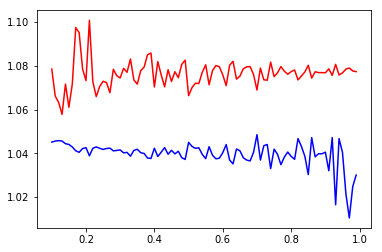

In [275]:
plt.plot(np.arange(0.1,1.0,0.01), training_error_total[9:], color='r')
plt.plot(np.arange(0.1,1.0,0.01), test_error_total[9:], color='b')
plt.show()